# Continuous Control

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [2]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.4 which is incompatible.


The environments corresponding to both versions of the environment are already saved in the Workspace and can be accessed at the file paths provided below.  

Please select one of the two options below for loading the environment.

In [3]:
from unityagents import UnityEnvironment
import numpy as np

# select this option to load version 1 (with a single agent) of the environment
env = UnityEnvironment(file_name='/data/Reacher_One_Linux_NoVis/Reacher_One_Linux_NoVis.x86_64')

# select this option to load version 2 (with 20 agents) of the environment
# env = UnityEnvironment(file_name='/data/Reacher_Linux_NoVis/Reacher.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [4]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 1
Size of each action: 4
There are 1 agents. Each observes a state with length: 33
The state for the first agent looks like: [  0.00000000e+00  -4.00000000e+00   0.00000000e+00   1.00000000e+00
  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00  -1.00000000e+01   0.00000000e+00
   1.00000000e+00  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   5.75471878e+00  -1.00000000e+00
   5.55726671e+00   0.00000000e+00   1.00000000e+00   0.00000000e+00
  -1.68164849e-01]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [5]:
env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 0.05999999865889549


When finished, you can close the environment.

In [ ]:
# env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 

In [8]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pickle


# it will send the tensor to CPU or GPU (if available)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Create a Replay Buffer to store the experience (State, Action, Reward, Done).
class ReplayBuffer:

    def __init__(self, memory_size, state_dims, n_actions):
        """
        Arguments:
        memory_size -- scalar, total number of experiences that the Replay Buffer can store
        state_dim -- list, the size of the state Example: Vector  [10], pixels [80,80]
        action_dim -- list, the size of the action
        """

        self.memory_size = memory_size
        self.state = np.zeros((memory_size, state_dims))
        self.action = np.zeros((memory_size, n_actions))
        self.reward = np.zeros((memory_size, 1))
        self.next_state = np.zeros((memory_size, state_dims))
        self.done = np.zeros((memory_size, 1))
        self.count = 0
        self.index = 0

    def add(self, state, action, reward, next_state, done):

        # store the experience on the position = Index    
        # state, action, reward, next_state ==>  type(numpy array)
        self.state[self.index] = state
        self.action[self.index] = action
        self.reward[self.index] = reward
        self.next_state[self.index] = next_state
        self.done[self.index] = done

        # define the position (index) where we want to store the next experience
        if self.index == self.memory_size - 1:
            self.index = 0
        else:
            self.index = self.index + 1

        # keep track of total experiences we already saved
        self.count = self.count + 1

    def sample(self, batch_size):

        # random select some examples from the Replay Buffer
        idx = np.random.choice(np.arange(min(self.count, self.memory_size)), batch_size)
        states = self.state[idx]
        actions = self.action[idx]
        rewards = self.reward[idx]
        next_states = self.next_state[idx]
        dones = self.done[idx]

        return states, actions, rewards, next_states, dones


# Create a Noise to add in the action in order to make the agent explore the environment: Ornstein–Uhlenbeck (OU)
class OUActionNoise:
    def __init__(self, mu=np.array([[0,0,0,0]]), theta=0.03, sigma=0.03, dt=0.01, x0=None):
        self.mu = mu                                # np.array shape [1, n_actions], the noise will converge to mu
        self.theta = theta                          # scalar, how fast the noise will converge to mu
        self.sigma = sigma                          # scalar, the volatility of the noise
        self.dt = dt                                # scalar, how fast the noise will converge to mu
        self.x0 = x0                                # np.array shape [1, n_actions], initial value of the noise
        self.x_prev = self.x0
        self.reset()

    def __call__(self):
        x = self.x_prev + self.theta * (self.mu - self.x_prev) * self.dt + self.sigma * np.sqrt(
            self.dt) * np.random.normal(size=self.mu.shape)
        self.x_prev = x
        return x

    def reset(self):
        if self.x0 is None:
            self.x_prev = np.zeros(self.mu.shape)

            
class Actor(nn.Module):
    """
    Actor will be the policy.  It will choose the best action to take, one action for each State (Deterministic Policy)
    """

    def __init__(self, learning_rate, state_dims, n_actions, action_bound, fc1_dims, fc2_dims):
        super(Actor, self).__init__()
        self.learning_rate = learning_rate                   # learning rate
        self.state_dim = state_dims                          # number of features on the state
        self.n_actions = n_actions                           # number of actions
        self.action_bound = action_bound                     # maximum absolute value of each action

        # Create the Layers and initialize the parameters according the paper DDPG
        self.fc1 = nn.Linear(in_features=state_dims, out_features=fc1_dims)
        self.fc2 = nn.Linear(in_features=fc1_dims, out_features=fc2_dims)
        self.fc3 = nn.Linear(in_features=fc2_dims, out_features=n_actions)


        # initialize the parameters with a uniform distribution
        # each number btw -f and f has the same probability to be chosen as a parameter (weight and bias)
        f1 = 1 / np.sqrt(fc1_dims)
        torch.nn.init.uniform_(self.fc1.weight, -f1, f1)
        torch.nn.init.uniform_(self.fc1.bias, -f1, f1)

        f2 = 1 / np.sqrt(fc2_dims)
        torch.nn.init.uniform_(self.fc2.weight, -f2, f2)
        torch.nn.init.uniform_(self.fc2.bias, -f2, f2)

        f3 = 0.003
        torch.nn.init.uniform_(self.fc3.weight, -f3, f3)
        torch.nn.init.uniform_(self.fc3.bias, -f3, f3)
        
        # define the optimizer
        self.optimizer = optim.Adam(self.parameters(), lr=self.learning_rate)

    def forward(self, state):
        """
        Argument:
        s --   State, tensor shape(m_examples, n features)

        Return
        act --  Action, tensor shape(m_examples, n_actions)
        """
        s = self.fc1(state)
        s = F.relu(s)

        s = self.fc2(s)
        s = F.relu(s)

        s = self.fc3(s)
        s = torch.tanh(s)            # return values between [-1, 1]
        act = s * self.action_bound  # return values between [-action bound , action bound]

        return act

    
class Critic(nn.Module):
    """
    Critic will calculate the Q value of the state_action pair Q(s,a)
    """

    def __init__(self, learning_rate, state_dim, n_actions, fc1_dims, fc2_dims):
        super(Critic, self).__init__()
        self.learning_rate = learning_rate

        # Create the Layers and initialize  the parameters according the paper DDPG
        self.fc1 = nn.Linear(in_features=state_dim + n_actions, out_features=fc1_dims)
        self.fc2 = nn.Linear(in_features=fc1_dims, out_features=fc2_dims)
        self.fc3 = nn.Linear(in_features=fc2_dims, out_features=1)  # output = 1 dimension Q(s,a)


        # initialize the parameters with a uniform distribution
        # each number btw -f and f has the same probability to be chosen as a parameter (weight and bias)
        f1 = 1 / np.sqrt(fc1_dims)
        nn.init.uniform_(self.fc1.weight, -f1, f1)
        nn.init.uniform_(self.fc1.bias, -f1, f1)

        f2 = 1 / np.sqrt((fc2_dims + n_actions))
        nn.init.uniform_(self.fc2.weight, -f2, f2)
        nn.init.uniform_(self.fc2.bias, -f2, f2)

        f3 = 0.003
        nn.init.uniform_(self.fc3.weight, -f3, f3)
        nn.init.uniform_(self.fc3.bias, -f3, f3)


        # define the optimizer
        self.optimizer = optim.Adam(self.parameters(), lr=self.learning_rate)

    def forward(self, state, action):
        """
        Arguments:
        state --  State, tensor shape(m_examples, n_features)
        action -- Action chosen by the Actor, tensor shape(m_examples, n_actions)

        Return:
        q -- Q(s,a) Total Discounted Return of the State_Action pair, tensor shape (m examples, n_actions)
        """

        # include the action
        s = torch.cat((state, action), dim=1)

        s = self.fc1(s)
        s = F.relu(s)
        
        s = self.fc2(s)
        s = F.relu(s)

        s = self.fc3(s)


        return s


# Create an Agent to interact with the environment
class Agent:

    def __init__(self, n_actions, action_bound, state_dim, alfa, beta, fc1_dims, fc2_dims, tau, gamma, batch_size,
                 memory_size, episodic_task):
        self.n_actions = n_actions                # scalar, number of actions
        self.action_bound = action_bound          # scalar, maximum absolute value of the action
        self.state_dim = state_dim                # scalar, number of features on the state
        self.fc1_dims = fc1_dims                  # scalar, number of neurons on the 1st hidden layer
        self.fc2_dims = fc2_dims                  # scalar, number of neurons on the 2nd hidden layer
        self.alfa = alfa                          # scalar, learning rate of the Actor Network
        self.beta = beta                          # scalar, learning rate of Critic, need to learn faster than the actor
        self.tau = tau                            # scalar [0,1] Soft Update of Target Network: Actor and Critic << 1
        self.gamma = gamma                        # scalar [0,1] Discount Rate for future rewards
        self.batch_size = batch_size              # scalar, size of the mini batch - number os samples
        self.memory_size = memory_size            # scalar, maximum number of experiences to store on Replay Buffer
        self.episodic_task = episodic_task        # check if there is a terminal state

        # create a Replay Buffer to store the experiences (Break the Correlation in order to train the model)
        self.memory = ReplayBuffer(int(memory_size), state_dim, n_actions)

        # create 4 networks: Actor / Actor_Target and  Critic / Critic_Target
        self.actor = Actor(alfa, state_dim, n_actions, action_bound, fc1_dims, fc2_dims).to(device)
        self.actor_target = Actor(alfa, state_dim, n_actions, action_bound, fc1_dims, fc2_dims).to(device)

        self.critic = Critic(beta, state_dim, n_actions, fc1_dims, fc2_dims).to(device)
        self.critic_target = Critic(beta, state_dim, n_actions, fc1_dims, fc2_dims).to(device)

        # Initialize the Actor_Target and Critic_Target Parameters with the same values of the Actor and Critic tau=1
        self.update_parameters(tau=1)

        # initialize noise
        self.noise = OUActionNoise()

    def update_parameters(self, tau):

        # Soft update Actor Target:  actor_target = (1-tau) * actor_target + tau * actor
        for actor_target, actor in zip(self.actor_target.parameters(), self.actor.parameters()):
            actor_target.data.copy_((1 - tau) * actor_target + tau * actor)

        # Soft update Critic Target
        for critic_target, critic in zip(self.critic_target.parameters(), self.critic.parameters()):
            critic_target.data.copy_((1 - tau) * critic_target + tau * critic)

    def choose_action(self, state, noise_decay):
        # Convert the input to tensor
        state = torch.tensor(state, dtype=torch.float32).to(device)

        # The Critic Network will choose the best action and we will add a noise  (Exploration)
        noise = self.noise()*noise_decay
        action = np.array(self.actor(state).detach().to('cpu')) + noise

        return action

    def learn(self):

        # the Agent will learn only if we have enough experiences stored on the memory
        if self.memory.count >= self.batch_size:

            # random choose some experiences (S, A, R, S', done) from the Memory
            states, actions, rewards, next_states, dones = self.memory.sample(self.batch_size)

            # convert the experience into tensors
            states = torch.tensor(states, dtype=torch.float32).to(device)
            actions = torch.tensor(actions, dtype=torch.float32).to(device)
            rewards = torch.tensor(rewards, dtype=torch.float32).to(device)
            next_states = torch.tensor(next_states, dtype=torch.float32).to(device)
            dones = torch.tensor(dones, dtype=torch.float32).to(device)

            ######################################     TRAIN CRITIC  ##################################################
            # Find the Target to train the Critic Network.
            # If there isn't a Terminal_State, the game just end because the agent reaches the maximum number of steps
            # If there is Terminal State: Q_Value(terminal_State)=0 ==> done=1
            actions_target = self.actor_target(next_states)
            if self.episodic_task:
                target = rewards + self.gamma * self.critic_target(next_states, actions_target) * (1 - dones)
            else:
                target = rewards + self.gamma * self.critic_target(next_states, actions_target)

            # calculate the prediction of the Critic Network
            prediction = self.critic(states, actions)

            # calculate the loss of the Critic Network: Mean Square Error
            loss_critic = F.mse_loss(input=prediction, target=target)

            # zero previous gradients,  pytorch accumulates their values at each time we train the network
            self.critic.optimizer.zero_grad()

            # calculate the gradients
            loss_critic.backward()

            # update the parameters (weight and bias)
            self.critic.optimizer.step()

            ###################################     TRAIN ACTOR    ###################################################
            # We want to decide if we need to increase or decrease the value of the action on the Actor Network in order
            # to achieve a higher value of the Q(s, a) on the Critic Network.  Q(s,a) = Total Discounted Reward
            critic_actions = self.actor(states)

            q_state_action = self.critic(states, critic_actions)

            # Find the Loss: Maximize f(x) = Minimize -f(x).
            loss_actor = - torch.mean(q_state_action)

            # zero previous gradients,  pytorch accumulates their values at each time we train the network
            self.actor.optimizer.zero_grad()

            # calculate the gradients
            loss_actor.backward()

            # update the parameters (weight and bias)
            self.actor.optimizer.step()
            ###########################################################################################################

            # update parameters of the Actor_Target and Critic_Target with Soft Update
            self.update_parameters(self.tau)

            
                           # DDPG DEEP DETERMINISTIC POLICY GRADIENT 
    
# Create an Agent
agent = Agent(n_actions=4, action_bound=1, state_dim=33, alfa=0.0003, beta=0.0003, fc1_dims=400, fc2_dims=300, tau=0.03,
                  gamma=0.99, batch_size=32, memory_size=1e+5, episodic_task=False)

# save score of each episode
total_scores = []

step = 0

for episode in range(1, 1001):

    # reset the environment
    env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
    state = env_info.vector_observations                   # get the current state (for each agent)

    # reset the score of each episode
    score = 0
    
    # decay de noise every episode
    noise_decay = 0.97 ** episode
    
    while True:
        step = step + 1

        # agent will choose the best action to take
        actions = agent.choose_action(state, noise_decay)
        actions = np.clip(actions, -1, 1) 

        # take an action and receive a reward and go to the next_state
        env_info = env.step(actions)[brain_name]             # send all actions to tne environment
        next_state = env_info.vector_observations           # get next state (for each agent)
        rewards = env_info.rewards                          # get reward (for each agent)
        reward = np.array(rewards)
        done = env_info.local_done                          # see if episode finished

        # convert reward to a np, it was a list
        reward = np.array(rewards)

        # store the experiences
        agent.memory.add(state, actions, reward, next_state, done)

        # Train the model
        if step % 6 ==0:
            for i in range(4):
                agent.learn()

        # current state
        state = next_state

        # update score
        score = score + reward

        if np.any(done):
            total_scores.append(score)
            print('episode:{}.....reward:{:.2f}.....noise_decay:{:.2f}'.format(episode, float(score), noise_decay))
            break
        
    # save parameters 
    if len(total_scores) >= 100:
        if np.average(total_scores[-100:]) > 30:
            torch.save(agent.actor.state_dict(), 'actor_parameters.pt')
            torch.save(agent.actor_target.state_dict(), 'actor-target_parameters.pt')
            torch.save(agent.critic.state_dict(), 'critic_parameters.pt')
            torch.save(agent.critic_target.state_dict(), 'critic-target_parameters.pt')

            # save list of total_scores
            file_out = open('total_scores.pickle', 'wb')
            pickle.dump(total_scores, file_out)
            file_out.close() 
            print('problem solved!!!')
            break
            

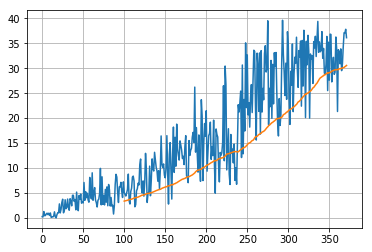

number of episodes: 372
average reward 100 consecutive episodes:30.59


In [77]:
import pickle
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

# load total rewards
file_in = open('total_scores.pickle', 'rb')
total_rewards = pickle.load(file_in)

# plot all rewards
plt.plot(total_rewards)

average = []
for i in range(100, len(total_rewards)):
    average.append(np.average(total_rewards[i-100: i]))

# plot the average reward of 100 conseutive episodes
plt.plot(np.arange(100, len(total_rewards)), average)

plt.grid()
plt.show()

print('number of episodes:', len(total_rewards))
print('average reward 100 consecutive episodes:{:.2f}'.format(np.average(total_rewards[-100:])))